# Estudio de la evolución de la pandemia por el modelo ARIMA para la isla de La Gomera

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def visualizar_STL(df):
    stl = STL(df, period=12)
    res = stl.fit()
    
    fig = res.plot()

    
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))

    plt.xticks(rotation=90)
    plt.show()
    

def visualizar_adf(df):
    ''' Visualiza el p-valor del estudio de Dickey-Fuller para determinar la estacionalidad de los datos
    
    Args:
        df (DataFrame): DataFrame con los datos a realizar el estudio (DataFrame con una única columna que es la objetivo)
    '''

    adf = adfuller(df)
    print("ADF p-value:" + str(adf[1]))
    

def visualizar_acf(df, n_lags):
    plt.figure(figsize=(16, 10))
    plot_acf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación')
    plt.title('ACF')
    plt.show()
    
def visualizar_pacf(df, n_lags):
    plt.figure(figsize=(16, 6))
    plot_pacf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación parcial')
    plt.title('PACF')
    plt.show()
    
    
def visualizar_dif_pred_test(test, pred, variable, tit):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
    
    Args:
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
        tit(string): título del gráfico
    '''
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(test.index, test, label='Test', color='green')
    plt.plot(test.index, pred, label='Predicción', color='orange')

    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.xticks(rotation=60)
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, tit, color, dif):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
        y muestra el historico de casos en función del número de días que indiquemos que muestre
    
    Args:
        train (DataFrame): Conjunto de datos de entrenamiento
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable (string): Variable objetivo
        dias_historico (integer): días hacia atrás a mostrar del historico
        tit (string): título del gráfico
        color (string): color de la isla para visualizar
    '''
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color)
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color)
        plt.plot(test.index, test, label='Test', color='green')
    
    plt.plot(test.index, pred, label='Predicción', color='orange')
    plt.bar(test.index, dif, width=0.5, color='black', alpha=0.2, align='edge', label='Diferencia')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(test.index), step=5),   train_s.index.union(test.index)[::5], rotation=70)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_bic_aic(modelo):
    ''' Visualiza los datos de BIC (Criterio de Información Bayesiano) y  AIC (Criterio de Información de Akaike)
    
    Args:
        modelo (ARIMA): modelo ARIMA entrenado
    '''
    
    bic = modelo.bic
    aic = modelo.aic

    print("BIC del modelo ARIMA:", bic)
    print("AIC del modelo ARIMA:", aic)
    
def visualizar_resultados_texto(y_test, y_pred, variable):
    ''' Método que visualiza por pantalla en formato de texto el número de csaos reales y los predichos por el algoritmo
    
    Args:
        y_test (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
    '''
    fechas = y_test.index
    for i in range(len(y_test)):
        if variable != '':
            valor_test = y_test[variable][i]
        else:
            valor_test = y_test[i] 
        print(str(fechas[i]) + ': número de casos reales ' + str(valor_test) + ', número de casos predichos ' + str(y_pred[i]))
        
def obtener_df_diferencias(test, pred, variable):
    df_result = test.copy()
    if variable != '':
        df_result = df_result[variable]
        df_result = df_result.to_frame()
    else:
        df_result = df_result.to_frame()
    df_result['pred'] = 0
    df_result['dif'] = 0

    for i in range(len(df_result)):
        df_result.iloc[i, df_result.columns.get_loc('pred')] = pred[i]
        df_result.iloc[i, df_result.columns.get_loc('dif')] = df_result['numero_casos'][i] - pred[i]
        
    return df_result

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos_islas = pd.read_csv('../data/Final/datos_reduc_final.csv', header=0)

# Obtenemos los datos de la isla a la que se le va a realizar el estudio
datos_LaGomera = datos_islas[datos_islas['isla'] == 'LA GOMERA'].copy()


datos_LaGomera = datos_LaGomera.sort_values(by='fecha')    # Ordenamos por fecha por si los datos devueltos no estuvieran en orden
datos_LaGomera.set_index('fecha', inplace=True)           # Añadimos como índice de los datos la fecha


In [4]:
# Variables globales a utilizar en todo el proceso

objetivo = 'numero_casos' # Variable objetivo
n_dias = 10               # Número de días correspondiente al conjunto de TEST
n_dias_train_vis = 100    # Número de días del conjunto de train a visualizar en el conjunto de train
color_isla = 'olive'       # Color de la isla en las visualizaciones
isla = 'La Gomera'        # Nombre de la isla para las visualizaciones    

variables_covid = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']   # Atributos para el análisis de las variables pandémicas
variables_atm = ['tmin', 'tmed', 'presMax']                         # Atributos para el análisis de las variables atmosféricas
variables = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables

In [5]:
# Obtenemos los conjuntos de datos para cada modelo con las variables necesarias para cada uno de ellos

datos_LaGomera_arima_uni = datos_LaGomera[objetivo]               # Datos modelo Univariable
datos_LaGomera_arima_mult_covid = datos_LaGomera[[objetivo] + variables_covid] # Datos modelo Multivariable con datos pandémicos
datos_LaGomera_arima_mult_atm = datos_LaGomera[[objetivo] + variables_atm]     # Datos modelo Multivariable con datos atmosféricos
datos_LaGomera_arima_total = datos_LaGomera.copy()                # Datos modelo Multivariable con todos los datos

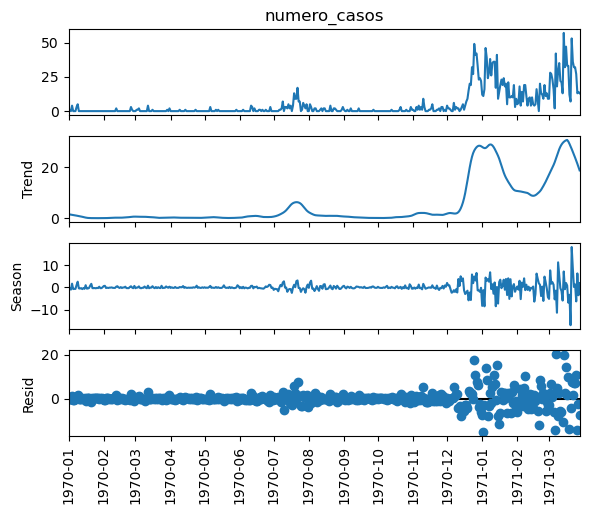

In [6]:
visualizar_STL(datos_LaGomera_arima_uni)

In [7]:
visualizar_adf(datos_LaGomera_arima_uni)

ADF p-value:0.23457306487474738


In [8]:
datos_LaGomera_arima_uni_1d = datos_LaGomera_arima_uni.diff().dropna()
visualizar_adf(datos_LaGomera_arima_uni_1d)

ADF p-value:1.6267026878849003e-06


<Figure size 1600x1000 with 0 Axes>

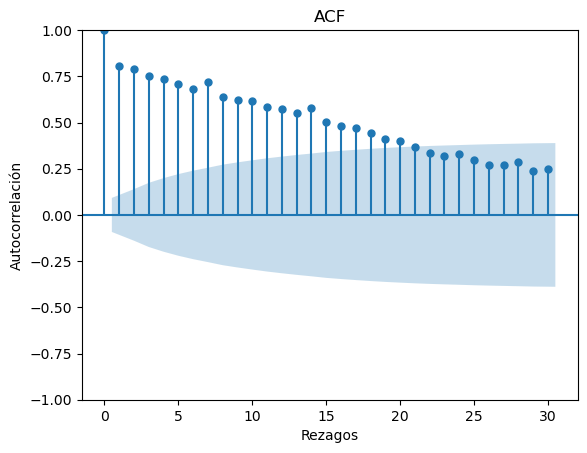

In [9]:
visualizar_acf(datos_LaGomera_arima_uni, 30)

<Figure size 1600x600 with 0 Axes>

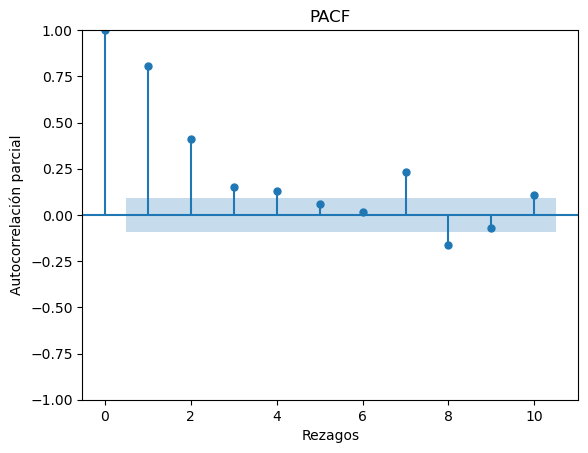

In [10]:
visualizar_pacf(datos_LaGomera_arima_uni, 10)

In [11]:
# Parámetros del modelo ARIMA
p = 4   # Parámetro Autorregresivo (AR)
d = 1   # Parámetro Integrado (I)
q = 7   # Parámetro Promedio Movil (MA)

# Modelo ARIMA univariable

In [12]:
# Conjuntos de entrenamiento y test
train = datos_LaGomera_arima_uni.iloc[:len(datos_LaGomera_arima_uni) - n_dias]
test =  datos_LaGomera_arima_uni.iloc[len(datos_LaGomera_arima_uni) - n_dias:]

In [13]:
arima_LaGomera = ARIMA(endog=train, order=(p, d, q), freq = 'D')
modelo_arima_LaGomera = arima_LaGomera.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [14]:
visualizar_bic_aic(modelo_arima_LaGomera)

BIC del modelo ARIMA: 2664.252742375246
AIC del modelo ARIMA: 2615.1842038698837


In [15]:
pred = modelo_arima_LaGomera.forecast(steps=n_dias)

In [16]:
visualizar_resultados_texto(test, pred, '')

2022-03-19: número de casos reales 12, número de casos predichos 30.845909076581652
2022-03-20: número de casos reales 7, número de casos predichos 32.09160703373177
2022-03-21: número de casos reales 53, número de casos predichos 36.9790100703005
2022-03-22: número de casos reales 36, número de casos predichos 32.12571307617617
2022-03-23: número de casos reales 32, número de casos predichos 29.88296940384759
2022-03-24: número de casos reales 32, número de casos predichos 38.14777904483395
2022-03-25: número de casos reales 27, número de casos predichos 32.36361629584963
2022-03-26: número de casos reales 13, número de casos predichos 31.198854762859618
2022-03-27: número de casos reales 14, número de casos predichos 34.54615101620489
2022-03-28: número de casos reales 13, número de casos predichos 34.712466070480595


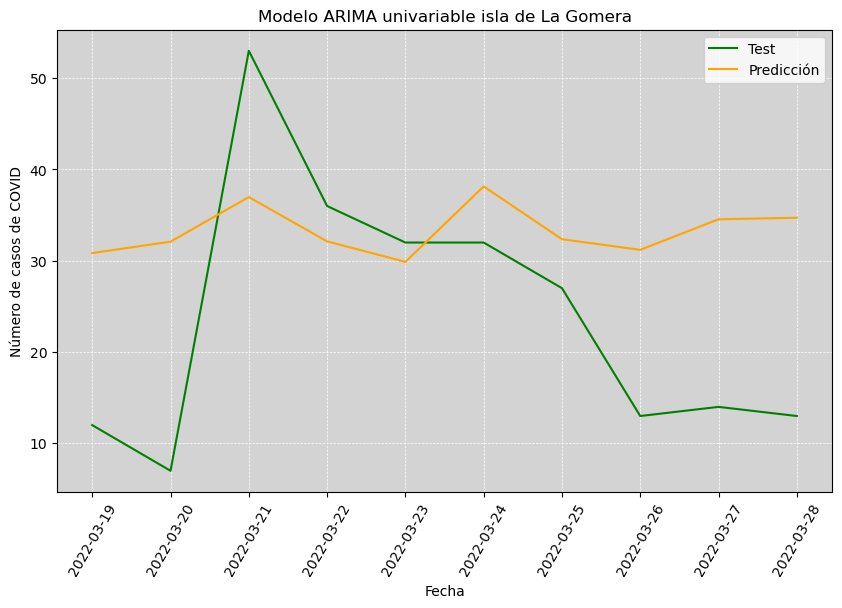

In [17]:
# Título para las visualizaciones
tit = 'Modelo ARIMA univariable isla de ' + isla
visualizar_dif_pred_test(test, pred, '', tit)

In [18]:
df_result = obtener_df_diferencias(test, pred, '')
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,12,30.845909,-18.845909
2022-03-20,7,32.091607,-25.091607
2022-03-21,53,36.979010,16.020990
2022-03-22,36,32.125713,3.874287
2022-03-23,32,29.882969,2.117031
2022-03-24,32,38.147779,-6.147779
2022-03-25,27,32.363616,-5.363616
2022-03-26,13,31.198855,-18.198855
2022-03-27,14,34.546151,-20.546151


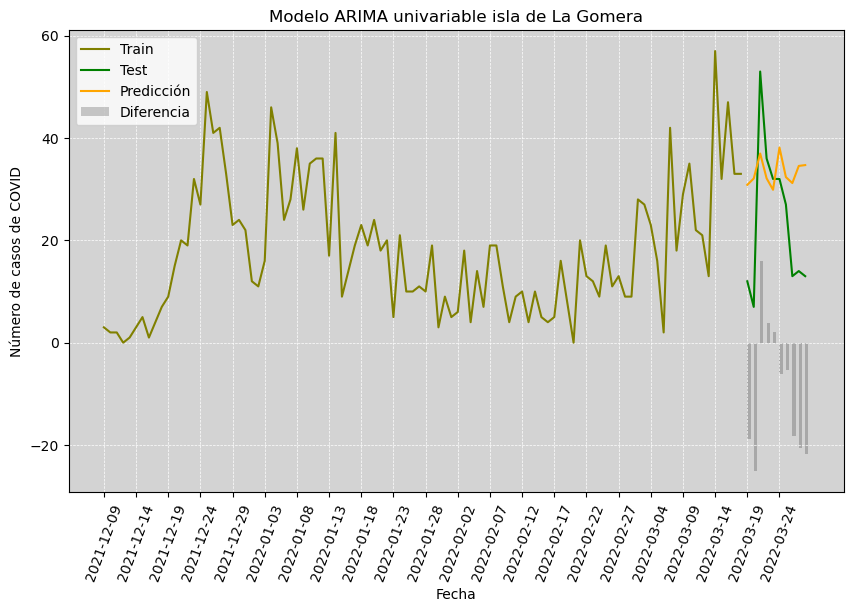

In [19]:
visualizar_historico(train, test, pred, '', n_dias_train_vis, tit, color_isla, df_result['dif'])

In [20]:
mae, mse, rmse = obtener_errores(test, pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 255.22584545740204
Error absoluto medio (MAE) del modelo: 13.791869075021784
Raíz del error cuadrático medio (RMSE) del modelo: 15.975789353186967


# Modelo ARIMA multivariable con variables de pandemia

In [21]:
train = datos_LaGomera_arima_mult_covid.iloc[:len(datos_LaGomera_arima_mult_covid) - n_dias]
test =  datos_LaGomera_arima_mult_covid.iloc[len(datos_LaGomera_arima_mult_covid) - n_dias:]

In [22]:
arima_LaGomera = ARIMA(endog=train[objetivo],exog=train[variables_covid], order=(p, d, q), freq = 'D')
modelo_arima_LaGomera = arima_LaGomera.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
visualizar_bic_aic(modelo_arima_LaGomera)

BIC del modelo ARIMA: 2606.8210589657097
AIC del modelo ARIMA: 2541.39634095856


In [24]:
pred = modelo_arima_LaGomera.forecast(steps=n_dias, exog=test[variables_covid])

In [25]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 12, número de casos predichos 30.369913060453953
2022-03-20: número de casos reales 7, número de casos predichos 27.99882552353268
2022-03-21: número de casos reales 53, número de casos predichos 40.86044428868145
2022-03-22: número de casos reales 36, número de casos predichos 30.714411360139326
2022-03-23: número de casos reales 32, número de casos predichos 31.16846863108624
2022-03-24: número de casos reales 32, número de casos predichos 39.010262544652456
2022-03-25: número de casos reales 27, número de casos predichos 29.64365221887526
2022-03-26: número de casos reales 13, número de casos predichos 30.660506733124173
2022-03-27: número de casos reales 14, número de casos predichos 30.63548304124773
2022-03-28: número de casos reales 13, número de casos predichos 32.885830601829


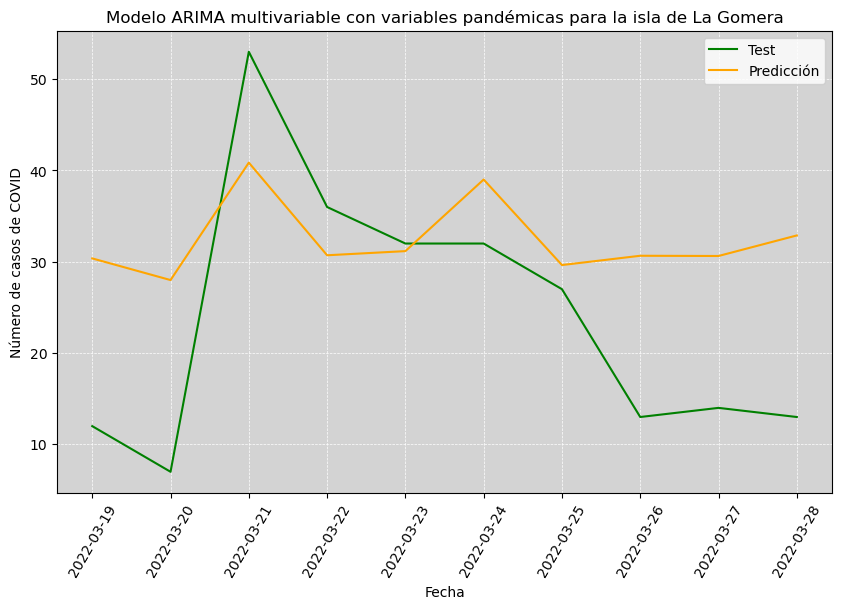

In [26]:
tit = 'Modelo ARIMA multivariable con variables pandémicas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

In [27]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,12,30.369913,-18.369913
2022-03-20,7,27.998826,-20.998826
2022-03-21,53,40.860444,12.139556
2022-03-22,36,30.714411,5.285589
2022-03-23,32,31.168469,0.831531
2022-03-24,32,39.010263,-7.010263
2022-03-25,27,29.643652,-2.643652
2022-03-26,13,30.660507,-17.660507
2022-03-27,14,30.635483,-16.635483


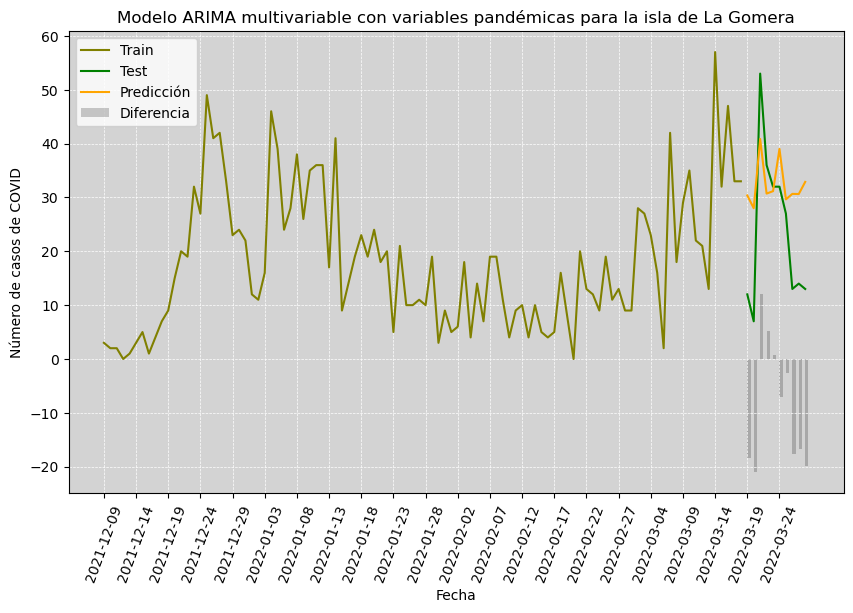

In [28]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

In [29]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 199.46138145822482
Error absoluto medio (MAE) del modelo: 12.146114944380823
Raíz del error cuadrático medio (RMSE) del modelo: 14.123079744100606


# Modelo ARIMA multivariable con variables atmosféricas

In [30]:
train = datos_LaGomera_arima_mult_atm.iloc[:len(datos_LaGomera_arima_mult_atm) - n_dias]
test =  datos_LaGomera_arima_mult_atm.iloc[len(datos_LaGomera_arima_mult_atm) - n_dias:]

In [31]:
arima_LaGomera = ARIMA(endog=train[objetivo],exog=train[variables_atm], order=(p, d, q), freq = 'D')
modelo_arima_LaGomera = arima_LaGomera.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [32]:
visualizar_bic_aic(modelo_arima_LaGomera)

BIC del modelo ARIMA: 2703.0161191328825
AIC del modelo ARIMA: 2641.68044600118


In [33]:
pred = modelo_arima_LaGomera.forecast(steps=n_dias, exog=test[variables_atm])

In [34]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 12, número de casos predichos 39.41048829322236
2022-03-20: número de casos reales 7, número de casos predichos 32.09911673920843
2022-03-21: número de casos reales 53, número de casos predichos 38.12677212188143
2022-03-22: número de casos reales 36, número de casos predichos 33.67903035363304
2022-03-23: número de casos reales 32, número de casos predichos 33.493693653627474
2022-03-24: número de casos reales 32, número de casos predichos 37.46437307661435
2022-03-25: número de casos reales 27, número de casos predichos 32.35635318377652
2022-03-26: número de casos reales 13, número de casos predichos 38.582509792508176
2022-03-27: número de casos reales 14, número de casos predichos 35.20926284061284
2022-03-28: número de casos reales 13, número de casos predichos 35.92058509432982


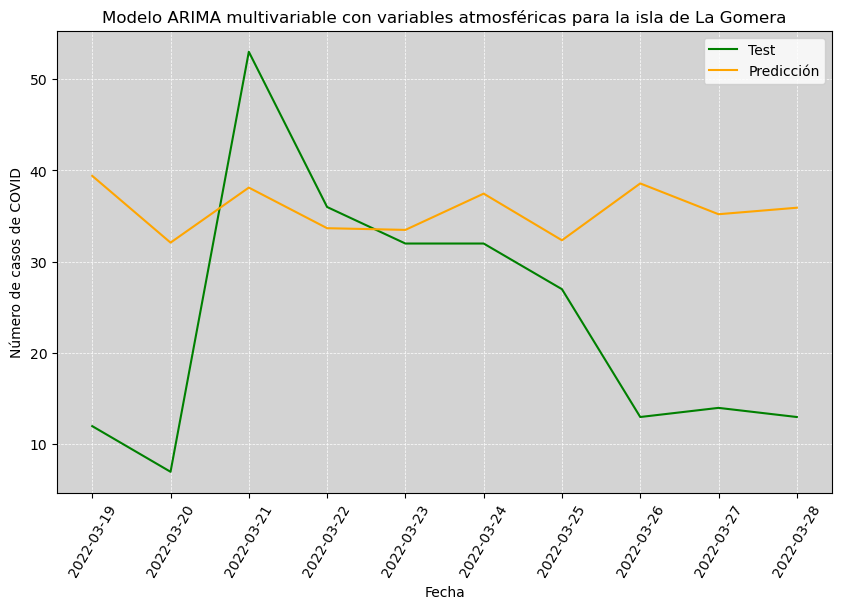

In [35]:
tit = 'Modelo ARIMA multivariable con variables atmosféricas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

In [36]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,12,39.410488,-27.410488
2022-03-20,7,32.099117,-25.099117
2022-03-21,53,38.126772,14.873228
2022-03-22,36,33.679030,2.320970
2022-03-23,32,33.493694,-1.493694
2022-03-24,32,37.464373,-5.464373
2022-03-25,27,32.356353,-5.356353
2022-03-26,13,38.582510,-25.582510
2022-03-27,14,35.209263,-21.209263


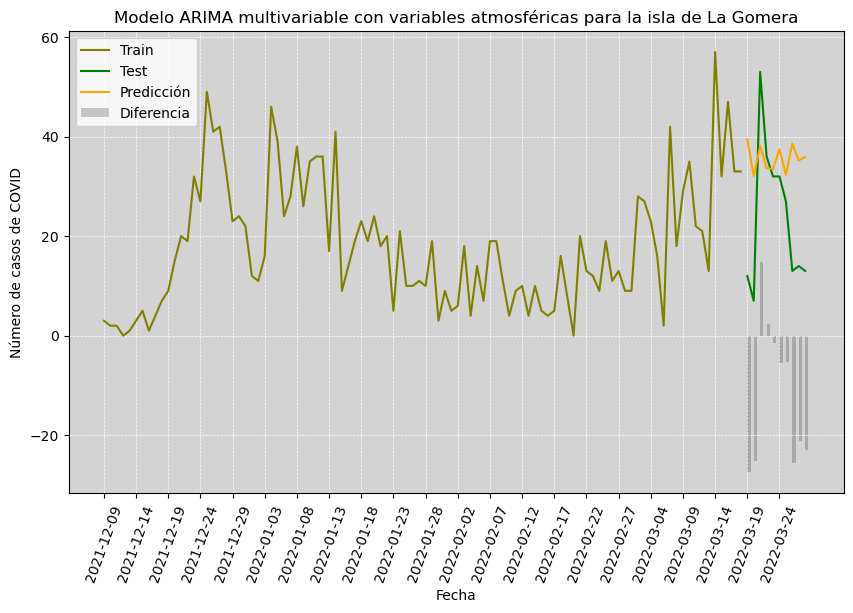

In [37]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

In [38]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 329.8332209048152
Error absoluto medio (MAE) del modelo: 15.17305801983855
Raíz del error cuadrático medio (RMSE) del modelo: 18.16131110093143


# Modelo ARIMA multivariable con todas las variables

In [39]:
train = datos_LaGomera_arima_total.iloc[:len(datos_LaGomera_arima_total) - n_dias]
test =  datos_LaGomera_arima_total.iloc[len(datos_LaGomera_arima_total) - n_dias:]

In [40]:
arima_LaGomera = ARIMA(endog=train[objetivo],exog=train[variables], order=(p, d, q), freq = 'D')
modelo_arima_LaGomera = arima_LaGomera.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
visualizar_bic_aic(modelo_arima_LaGomera)

BIC del modelo ARIMA: 2630.778936871391
AIC del modelo ARIMA: 2553.087084237901


In [42]:
pred = modelo_arima_LaGomera.forecast(steps=10, exog=test[variables])

In [43]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 12, número de casos predichos 32.98201499470409
2022-03-20: número de casos reales 7, número de casos predichos 30.77134476038401
2022-03-21: número de casos reales 53, número de casos predichos 41.03180726308253
2022-03-22: número de casos reales 36, número de casos predichos 32.33369011445559
2022-03-23: número de casos reales 32, número de casos predichos 33.173318072748756
2022-03-24: número de casos reales 32, número de casos predichos 38.920687125633606
2022-03-25: número de casos reales 27, número de casos predichos 32.04638748261699
2022-03-26: número de casos reales 13, número de casos predichos 32.050068028596655
2022-03-27: número de casos reales 14, número de casos predichos 33.12042699988757
2022-03-28: número de casos reales 13, número de casos predichos 34.14238326644042


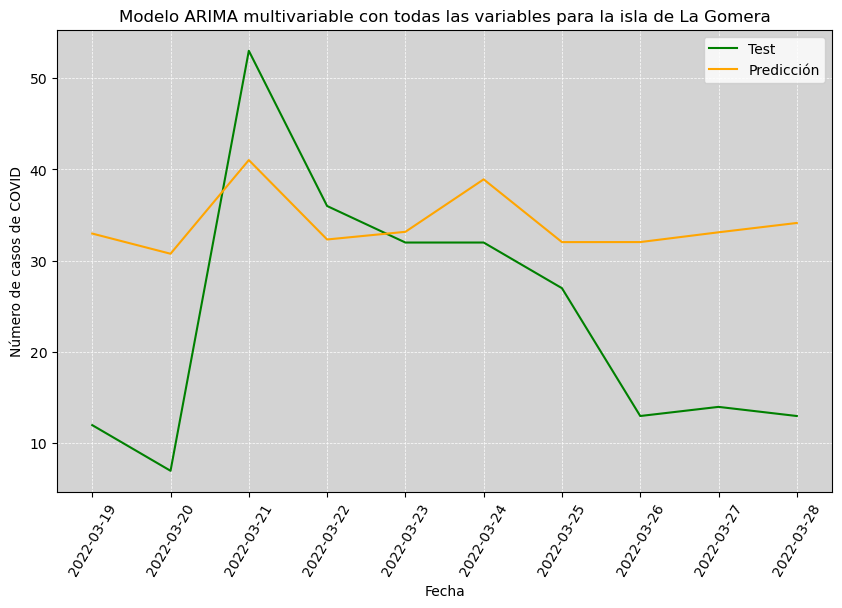

In [44]:
tit = 'Modelo ARIMA multivariable con todas las variables para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

In [45]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,12,32.982015,-20.982015
2022-03-20,7,30.771345,-23.771345
2022-03-21,53,41.031807,11.968193
2022-03-22,36,32.333690,3.666310
2022-03-23,32,33.173318,-1.173318
2022-03-24,32,38.920687,-6.920687
2022-03-25,27,32.046387,-5.046387
2022-03-26,13,32.050068,-19.050068
2022-03-27,14,33.120427,-19.120427


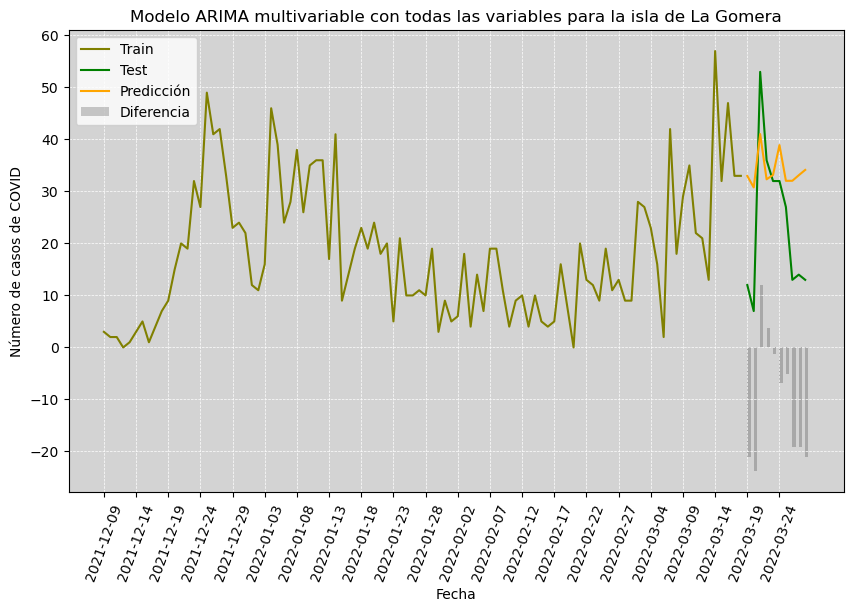

In [46]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla, df_result['dif'])

In [47]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 241.22360534725811
Error absoluto medio (MAE) del modelo: 13.2841133353474
Raíz del error cuadrático medio (RMSE) del modelo: 15.531374869832295
